In [275]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import cv2

import os, itertools, pickle
from pprint import pprint

from util import *
from config import *
%load_ext autoreload
%aimport util
%aimport config
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def next_k(it, k):
    return [next(it) for _ in range(k)][-1]

def show_img(imgs, figsize=(12, 9)):
    if type(imgs) != list:
        imgs = [imgs]
    plt.figure(figsize=figsize)
    alpha = 1
    alpha_dec = 1 / len(imgs)
    for img in imgs:
        plt.imshow(img, alpha=alpha)
        alpha -= alpha_dec
    plt.axis('off')
    plt.show()
    
def to_homo(x):
    for axis, size in enumerate(x.shape):
        if size == 2:
            break
    else:
        raise RuntimeError()
    ones_shape = list(x.shape)
    ones_shape[axis] = 1
    return np.concatenate((x, np.ones(ones_shape)), axis=axis)

def mult_homo(M, x):
    n, d = x.shape
    if d == 2:
        x = to_homo(x)
    output = np.dot(x, M.T)
    return output[:, :2] / output[:, 2:3]

In [278]:
frames = {}
for serie in 'pool_room', 'cory_breezeway', 'soda_front':
    calibrated_dir = Data + serie + '/calibrated/'
    videos = [read_video(get_data_path(calibrated_dir, i, name_is_dir=True)) for i in Cam_ids]
    k = 200
    for video in videos:
        for i, frame in enumerate(itertools.islice(video, 0, None, k)):
            frames.setdefault((serie, i * k), []).append(frame)

In [224]:
cameras = { i : np.load(os.path.join(Calibrations, str(i), 'camera_matrix.npy')) for i in range(1, Num_cameras + 1) }

In [264]:
# { (camera1, camera2) : ((y_min, y_max, x_min, x_max)1, (y_min, y_max, x_min, x_max)2) }
masks = {}
masks[(1, 2)] = ((0, Video_height, 2000, Video_width), (0, 600, 300, 2000))
masks[(1, 3)] = ((0, Video_height, 0, 700), (1500, Video_height, 0, 2100))
masks[(1, 4)] = ((0, 600, 300, 2000), (0, Video_height, 2150, Video_width))
masks[(1, 5)] = ((1400, Video_height, 600, 2100), (0, Video_height, 2000, Video_width))
masks[(2, 4)] = ((0, Video_height, 2100, Video_width), (0, 400, 650, 2100))
masks[(2, 5)] = ((0, Video_height, 0, 650), (1400, Video_height, 600, 2100))
masks[(2, 6)] = ((1600, Video_height, 800, 2350), (0, Video_height, 2150, Video_width))
masks[(3, 4)] = ((0, Video_height, 2000, Video_width), (1500, Video_height, 500, 2200))
masks[(3, 5)] = ((0, Video_height, 0, 500), (0, 400, 650, 2100))
masks[(3, 6)] = ((0, 500, 500, 2200), (0, Video_height, 0, 600))
masks[(4, 6)] = ((0, Video_height, 0, 700), (1400, Video_height, 300, 2100))
masks[(5, 6)] = ((0, Video_height, 0, 700), (0, 400, 600, 2250))

def get_mask(y_min, y_max, x_min, x_max):
    mask = np.zeros((Video_height, Video_width), dtype=np.uint8)
    mask[y_min : y_max, x_min : x_max] = 1
    return mask

def in_mask(kp, y_min, y_max, x_min, x_max):
    x, y = kp.pt
    return (y_min <= y < y_max) and (x_min <= x < x_max)

full_masks = {} # { camera : overlap of all masks }
for c in range(1, Num_cameras + 1):
    mask = None
    for (c1, c2), (cors1, cors2) in masks.items():
        if c1 == c:
            cors = cors1
        elif c2 == c:
            cors = cors2
        else:
            continue
        new_mask = get_mask(*cors)
        if mask is None:
            mask = new_mask
        else:
            mask |= new_mask
    full_masks[c] = mask

In [ ]:
for (c1, c2), (corners1, corners2) in masks.items():
    show_img([frames[c1], get_mask(*corners1)], figsize=(8, 6))
    show_img([frames[c2], get_mask(*corners2)], figsize=(8, 6))

In [347]:
def compute_keypoints(frames, masks, full_masks):
    keypoints = {} # { camera : (keypoints, descriptors)}
    for im, mask in full_masks.items():
        sift = cv2.xfeatures2d.SIFT_create()
        kp, des = sift.detectAndCompute(frames[im], mask)
        keypoints[im] = (kp, des)

    def select_kps(kps, cors):
        return [i for i, p in enumerate(kps) if in_mask(p, *cors)]
    
    correspondences = {}
    for (c1, c2), (cors1, cors2) in masks.items():
        kp_ids1, kp_ids2 = (select_kps(keypoints[c1][0], cors1), select_kps(keypoints[c2][0], cors2))
        kp1, des1 = keypoints[c1]
        kp2, des2 = keypoints[c2]
        des1_masked = np.array([des1[i] for i in kp_ids1])
        des2_masked = np.array([des2[i] for i in kp_ids2])

        k = 2
        if len(des1_masked) < k or len(des2_masked) < k:
            continue
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1_masked, des2_masked, k=k)
        
        good = [m for m, n in matches if m.distance < 0.6 * n.distance]
        match_indices = [(kp_ids1[m.queryIdx], kp_ids2[m.trainIdx]) for m in good]
        correspondences[(c1, c2)] = match_indices
#         print('%s correspondences between images %s and %s' % (len(match_indices), c1, c2))
    return keypoints, correspondences

In [349]:
index_maps = { c : {} for c in Cam_ids }
merged_keypoints = { c : [] for c in Cam_ids }
merged_correspondences = {}
for label, fs in frames.items():
    print(label)
    fs = { i + 1 : f for i, f in enumerate(fs) }
    keypoints, correspondences = compute_keypoints(fs, masks, full_masks)
    for pair, match_indices in correspondences.items():
        indices_list = zip(*match_indices)
        for c, indices in zip(pair, indices_list):
            index_map = index_maps[c]
            kps = keypoints[c][0]
            for index in indices:
                if index not in index_map:
                    index_map[index] = len(index_map)
                    merged_keypoints[c].append(kps[index])
        c1, c2 = pair
        for i1, i2 in match_indices:
            merged_correspondences.setdefault(pair, []).append((index_maps[c1][i1], index_maps[c2][i2]))

('pool_room', 400)
('soda_front', 800)
('cory_breezeway', 1200)
('soda_front', 600)
('cory_breezeway', 1000)
('pool_room', 1000)
('cory_breezeway', 0)
('pool_room', 1200)
('pool_room', 600)
('cory_breezeway', 1800)
('soda_front', 400)
('cory_breezeway', 800)
('soda_front', 200)
('cory_breezeway', 600)
('pool_room', 1400)
('pool_room', 0)
('soda_front', 1200)
('cory_breezeway', 1600)
('soda_front', 1000)
('cory_breezeway', 1400)
('soda_front', 0)
('cory_breezeway', 400)
('pool_room', 800)
('cory_breezeway', 200)
('pool_room', 200)


In [352]:
[(k, len(x)) for k , x in merged_correspondences.items()]

[((1, 2), 583),
 ((1, 3), 502),
 ((4, 6), 958),
 ((5, 6), 580),
 ((1, 4), 422),
 ((1, 5), 501),
 ((2, 6), 633),
 ((3, 6), 303),
 ((2, 5), 535),
 ((3, 4), 356),
 ((2, 4), 383),
 ((3, 5), 359)]

In [353]:
import sys
sys.path.append(Root + 'OpenSfM/')

In [354]:
from opensfm import matching
features = { cam : mult_homo(np.linalg.inv(cameras[cam]), np.array([x.pt for x in kps])) for cam, kps in merged_keypoints.items() }
colors = { cam : [(0, 0, 0) for _ in kps] for cam, kps in merged_keypoints.items() }
run_config = { 'min_track_length' : 2, 'processes' : 5 }
tracks_graph = matching.create_tracks_graph(features, colors, merged_correspondences, run_config)

2018-01-21 15:00:24,420 DEBUG: Merging features onto tracks
2018-01-21 15:00:24,490 DEBUG: Good tracks: 2654


<module 'opensfm.reconstruction' from '/scratch/zxyan/bdd/OpenSfM/opensfm/reconstruction.pyc'>

In [435]:
from opensfm import reconstruction
from opensfm import dataset
from opensfm import types
import opensfm.config
import yaml
reload(reconstruction)

class DataMock(dataset.DataSet):
    def __init__(self):
        self.reference_lla = None
        self.config = yaml.load(opensfm.config.default_config_yaml)
        self.config.update(run_config)
    
    def reference_lla_exists(self):
        return self.reference_lla is not None
    
    def save_reference_lla(self, ref):
        self.reference_lla = ref

    def load_reference_lla(self):
        return self.reference_lla
        
    def images(self):
        return list(range(1, Num_cameras + 1))
    
    def load_exif(self, cam_index):
        cam_mat = cameras[cam_index]
        return {
            'width' : Video_width / cam_mat[0, 0],
            'height' : Video_height / cam_mat[1, 1],
            'focal_prior' : 1,
            'camera' : cam_index
        }
    
    def load_tracks_graph(self):
        return tracks_graph
    
    def ground_control_points_exist(self):
        return False
    
    def load_camera_models(self):
        def create_camera(i):
            cam_mat = cameras[i]
            camera = types.PerspectiveCamera()
            camera.id = i
            camera.width = Video_width / cam_mat[0, 0]
            camera.height = Video_height / cam_mat[1, 1]
            camera.focal = camera.focal_prior = 1
            camera.k1 = camera.k1_prior = 0
            camera.k2 = camera.k2_prior = 0
            return camera
        return { i : create_camera(i) for i, camera in cameras.items() }
    
    def save_reconstruction(self, reconstructions, filename=None, minify=False):
        self.reconstructions = reconstructions
    
    def load_reconstruction(self, filename=None):
        return self.reconstructions
    
data = DataMock()

def incremental_reconstruction(data):
    """Run the entire incremental reconstruction pipeline."""
    logger.info("Starting incremental reconstruction")
    report = {}
    chrono = Chronometer()
    if not data.reference_lla_exists():
        data.invent_reference_lla()

    graph = data.load_tracks_graph()
    tracks, images = matching.tracks_and_images(graph)
    chrono.lap('load_tracks_graph')
    remaining_images = set(images)
    gcp = None
    if data.ground_control_points_exist():
        gcp = data.load_ground_control_points()
    common_tracks = matching.all_common_tracks(graph, tracks)
    reconstructions = []
    pairs = compute_image_pairs(common_tracks, data)
    logger.info(pairs)
    chrono.lap('compute_image_pairs')
    report['num_candidate_image_pairs'] = len(pairs)
    report['reconstructions'] = []
    for im1, im2 in pairs:
        if im1 in remaining_images and im2 in remaining_images:
            rec_report = {}
            report['reconstructions'].append(rec_report)
            tracks, p1, p2 = common_tracks[im1, im2]
            reconstruction, rec_report['bootstrap'] = bootstrap_reconstruction(
                data, graph, im1, im2, p1, p2)

            if reconstruction:
                remaining_images.remove(im1)
                remaining_images.remove(im2)
                reconstruction, rec_report['grow'] = grow_reconstruction(
                    data, graph, reconstruction, remaining_images, gcp)
                reconstructions.append(reconstruction)
                reconstructions = sorted(reconstructions,
                                         key=lambda x: -len(x.shots))
                data.save_reconstruction(reconstructions)

    for k, r in enumerate(reconstructions):
        logger.info("Reconstruction {}: {} images, {} points".format(
            k, len(r.shots), len(r.points)))
    logger.info("{} partial reconstructions in total.".format(
        len(reconstructions)))
    chrono.lap('compute_reconstructions')
    report['wall_times'] = dict(chrono.lap_times())
    report['not_reconstructed_images'] = list(remaining_images)
    return report
# reconstruction.incremental_reconstruction = incremental_reconstruction
reconstruction.incremental_reconstruction(data)

2018-01-21 16:21:07,303 INFO: Starting incremental reconstruction
2018-01-21 16:21:10,447 INFO: [(1, 2), (2, 6), (1, 5), (3, 4), (4, 6), (2, 5), (2, 4), (1, 4), (1, 3), (5, 6), (3, 6), (3, 5)]
2018-01-21 16:21:10,453 INFO: Starting reconstruction with 1 and 2
2018-01-21 16:21:10,541 INFO: Two-view reconstruction inliers: 393 / 481
2018-01-21 16:21:10,592 INFO: Triangulated: 396
2018-01-21 16:21:10,599 DEBUG: Ceres Solver Report: Iterations: 3, Initial cost: 8.222723e+00, Final cost: 8.131823e+00, Termination: CONVERGENCE
2018-01-21 16:21:10,667 DEBUG: Ceres Solver Report: Iterations: 3, Initial cost: 8.152235e+00, Final cost: 8.122252e+00, Termination: CONVERGENCE
2018-01-21 16:21:10,815 DEBUG: Ceres Solver Report: Iterations: 51, Initial cost: 3.256639e+01, Final cost: 2.215462e+01, Termination: NO_CONVERGENCE
2018-01-21 16:21:10,819 INFO: -------------------------------------------------------
2018-01-21 16:21:10,820 INFO: Some images can not be added
2018-01-21 16:21:10,821 INFO: --

{'not_reconstructed_images': [],
 'num_candidate_image_pairs': 12,
 'reconstructions': [{'bootstrap': {'common_tracks': 481,
    'decision': 'Success',
    'image_pair': (1, 2),
    'memory_usage': 5244108800,
    'triangulated_points': 396,
    'two_view_reconstruction': {'5_point_inliers': 393,
     'method': '5_point',
     'plane_based_inliers': 372}},
   'grow': {'steps': []}},
  {'bootstrap': {'common_tracks': 289,
    'decision': 'Success',
    'image_pair': (3, 4),
    'memory_usage': 5244108800,
    'triangulated_points': 259,
    'two_view_reconstruction': {'5_point_inliers': 239,
     'method': '5_point',
     'plane_based_inliers': 204}},
   'grow': {'steps': []}},
  {'bootstrap': {'common_tracks': 125,
    'decision': 'Success',
    'image_pair': (5, 6),
    'memory_usage': 5244108800,
    'triangulated_points': 101,
    'two_view_reconstruction': {'5_point_inliers': 101,
     'method': '5_point',
     'plane_based_inliers': 100}},
   'grow': {'steps': []}}],
 'wall_times'

In [436]:
rs = data.load_reconstruction()

In [437]:
transformations = { im : (x.pose.get_rotation_matrix(), x.pose.translation) for r in rs for im, x in r.shots.items() }
R1, t1 = transformations[1]
trans1 = {} # camera 1 point of reference
for im, (Ri, ti) in transformations.items():
    R = np.dot(Ri, R1.T)
    trans1[im] = (R, ti - np.dot(R, t1))
trans1

{1: (array([[  1.00000000e+00,   1.55548023e-18,  -6.93474255e-18],
         [  1.55548023e-18,   1.00000000e+00,  -2.94817128e-18],
         [ -6.93474255e-18,  -2.94817128e-18,   1.00000000e+00]]),
  array([ -4.44089210e-16,   0.00000000e+00,   0.00000000e+00])),
 2: (array([[ 0.07449526, -0.99720615, -0.00550825],
         [-0.13674328, -0.00474353, -0.99059516],
         [ 0.98780146,  0.07454786, -0.13671461]]),
  array([-0.36075196,  0.49436254,  4.07025784])),
 3: (array([[ 0.99988707,  0.01473158,  0.00297153],
         [-0.0146786 ,  0.99974561, -0.01712479],
         [-0.00322305,  0.01707923,  0.99984894]]),
  array([ 0.01138758,  0.45821072, -0.17173804])),
 4: (array([[ 0.04731907,  0.99880432, -0.01228126],
         [ 0.11376182,  0.0068263 ,  0.9934846 ],
         [ 0.99238055, -0.0484079 , -0.11330279]]),
  array([ 0.48957148, -0.43405104,  4.02746834])),
 5: (array([[  9.95930072e-01,   1.97614650e-02,  -8.79362095e-02],
         [ -1.98910448e-02,   9.99801975e-01,  -

In [438]:
Rts_test = [transformations[1], transformations[2]]

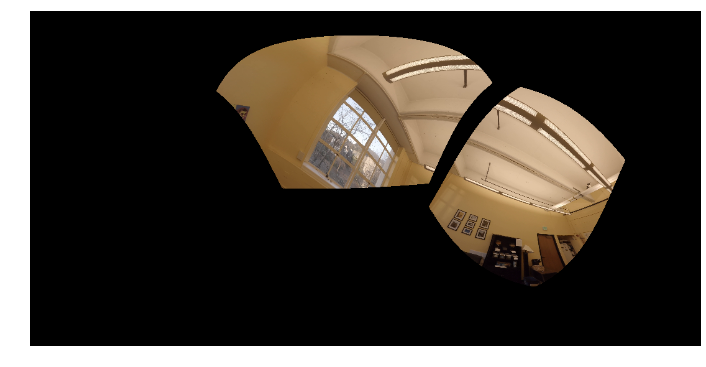

In [434]:
scale = 3
p_w, p_h = 360 * scale, 180 * scale
px_to_rad = lambda x: x / scale * np.pi / 180
p = np.zeros((p_h, p_w, 3), dtype=np.uint8)
shift_x, shift_y = Video_wh / 2
in_range = lambda x, min_x, max_x: min_x <= x < max_x
is_inbound = lambda x, y: (0 <= x < Video_width) and (0 <= y < Video_height)
for i in range(p_w):
    theta = px_to_rad(i - p_w // 2) 
    for j in range(p_h):
        phi = px_to_rad(j - p_h // 2)
        vec = np.array([np.sin(theta) * np.cos(phi), np.sin(phi), np.cos(theta) * np.cos(phi)])
        
        for c, f, (R, t) in zip(Cam_ids, fs, Rts_test):
            if R is None or t is None:
                continue
            x_t, y_t, z_t = np.dot(R, vec)
            cam_mtx = cameras[c]
            if z_t > 0:
                x_f = int(round(x_t / z_t * cam_mtx[0, 0] + cam_mtx[0, 2]))
                y_f = int(round(y_t / z_t * cam_mtx[1, 1] + cam_mtx[1, 2]))
                if is_inbound(x_f, y_f):
                    p[j, i] = f[y_f, x_f]
                    continue
show_img(p)

In [362]:
Rts = [trans1[i] for i in Cam_ids]
fs = frames[frames.keys()[0]]

In [363]:
Rts

[(array([[  1.00000000e+00,  -1.02711578e-17,  -6.17311195e-18],
         [ -1.02711578e-17,   1.00000000e+00,   7.26924334e-17],
         [ -6.17311195e-18,   7.26924334e-17,   1.00000000e+00]]),
  array([  0.00000000e+00,  -1.11022302e-16,   0.00000000e+00])),
 (array([[  5.79011792e-02,  -9.98296915e-01,  -7.12199049e-03],
         [ -1.14856871e-01,   4.25232826e-04,  -9.93381960e-01],
         [  9.91693175e-01,   5.83359964e-02,  -1.14636638e-01]]),
  array([-0.29953676,  0.38832907,  4.0478093 ])),
 (array([[ 0.99731604,  0.06427368, -0.03506571],
         [-0.04137746,  0.09965884, -0.99416096],
         [-0.06040378,  0.99294361,  0.10205084]]),
  array([ 0.02471153,  0.45423332,  0.52077092])),
 (array([[ 0.01447785,  0.10790637, -0.99405564],
         [ 0.07198752,  0.99146749,  0.10867388],
         [ 0.99730045, -0.07313296,  0.0065864 ]]),
  array([ 0.50888485,  0.21893192,  3.96113879])),
 (array([[ 0.99300823, -0.04243825, -0.11015284],
         [-0.0154684 ,  0.8783156

In [428]:
I = np.eye(3)
z = np.zeros(3)
Rts = [
    (I, z),
    (np.array([-I[1], -I[2], I[0]]), z),
    (np.array([-I[1], I[2], -I[0]]), z),
    (np.array([I[2], -I[0], -I[1]]), z),
    (np.array([I[2], I[0], I[1]]), z),
    (np.array([I[0], -I[1], -I[2]]), z),
]

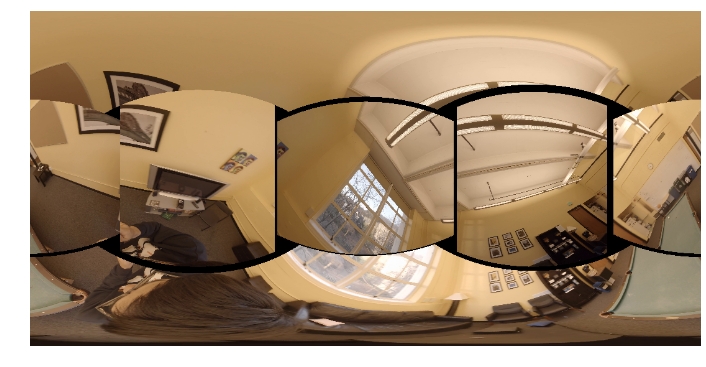

In [429]:
scale = 3
p_w, p_h = 360 * scale, 180 * scale
px_to_rad = lambda x: x / scale * np.pi / 180
p = np.zeros((p_h, p_w, 3), dtype=np.uint8)
shift_x, shift_y = Video_wh / 2
in_range = lambda x, min_x, max_x: min_x <= x < max_x
is_inbound = lambda x, y: (0 <= x < Video_width) and (0 <= y < Video_height)
for i in range(p_w):
    theta = px_to_rad(i - p_w // 2) 
    for j in range(p_h):
        phi = px_to_rad(j - p_h // 2)
        vec = np.array([np.sin(theta) * np.cos(phi), np.sin(phi), np.cos(theta) * np.cos(phi)])
        
        for c, f, (R, t) in zip(Cam_ids, fs, Rts):
            if R is None or t is None:
                continue
            x_t, y_t, z_t = np.dot(R, vec) 
            cam_mtx = cameras[c]
            if z_t > 0:
                x_f = int(round(x_t / z_t * cam_mtx[0, 0] + cam_mtx[0, 2]))
                y_f = int(round(y_t / z_t * cam_mtx[1, 1] + cam_mtx[1, 2]))
                if is_inbound(x_f, y_f):
                    p[j, i] = f[y_f, x_f]
                    continue
show_img(p)